In [1]:
import gym
import gym_examples
import numpy as np
from copy import deepcopy, copy
import warnings
import itertools
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from utils import render_rgb, action_arrow, opponent_random

In [2]:
env = gym.make('GridWorld-v0', render_mode='human')
env.reset()
env.render()

In [3]:
# assign step returns
observation, reward, terminated, truncated, info = env.step(3)
print(f'Observation: {observation}\nReward: {reward}\nTerminated: {terminated}\nTruncated: {truncated}\nInfo: {info}')
env.close()

Observation: {'agent': array([2, 3]), 'target': array([1, 4])}
Reward: 0
Terminated: False
Truncated: False
Info: {'distance': 2.0}


In [4]:
# Action space
print(f'Action space: {env.action_space}')

Action space: Discrete(4)


In [36]:
class Node():
    def __init__(self, state, action, env, mcts, action_list, visits=0, rewards=0, parent=None):
        self.state = state
        self.action = action
        self.action_list = action_list
        self.children = []
        self.visits = visits
        self.sum_rewards = rewards
        self.parent = parent
        # self.env = env
        self.mcts = mcts

        # Env specific
        if self.mcts.env.spec.id == 'tictactoe-v0':
            self.unexplored_actions = self.mcts.env.get_valid_moves()
        elif self.mcts.env.spec.id == 'GridWorld-v0':
            self.unexplored_actions = action_list
    
    def add_child(self, child):
        child = child
        self.children.append(child)
    
    def get_value(self):
        return self.sum_rewards / self.visits if self.visits > 0 else 0
    
    def uct_value(self, parent_visits, c=1.4):
        # c is a constant that controls the degree of exploration

        # If the node or parent has not been visited, return infinity
        if self.visits == 0 or parent_visits == 0:
            return np.inf
        # Otherwise, return the standard UCT value
        else:
            return self.get_value() + c * np.sqrt(np.log(parent_visits) / self.visits)
    
    def selection(self):
        # check if the node has unexplored actions
        if len(self.unexplored_actions) > 0:
            return self
        # if not, select the child with the highest UCT value
        else:
            uct_values = [child.uct_value(self.visits) for child in self.children]
            try:
                max_child = self.children[np.argmax(uct_values)]
            except ValueError as e:
                print('Error: ', e)
            return max_child.selection()
        
    def expansion(self):
        # Randomly choose an unexplored action
        expand_index = np.random.choice(len(self.unexplored_actions))
        expand_action = self.unexplored_actions[expand_index]
        if self.mcts.env.spec.id == 'tictactoe-v0':
            expand_action = (0, expand_action)
        obs, reward, terminated, truncated, info = self.mcts.env.step(expand_action)
        new_node = Node(state=obs, action=expand_action, mcts=self.mcts, env=self.mcts.env, action_list=self.action_list, parent=self)
        self.children.append(new_node)
        self.unexplored_actions = np.delete(self.unexplored_actions,np.where(self.unexplored_actions==expand_action[1]))
        return new_node

    def rollout(self):
        if self.mcts.env.spec.id == 'GridWorld-v0':
            return self.rollout_gridworld()
        elif self.mcts.env.spec.id == 'tictactoe-v0':
            return self.rollout_tictactoe()
        else:
            raise NotImplementedError
        
    def rollout_gridworld(self):
        terminated = False
        total_reward = 0
        # Limit the rollout to k=4*size steps (as GridWorld is potentially infinite)
        k = 4 * self.mcts.env.size
        for _ in range(k):
            # Random rollout policy
            action = np.random.choice(self.mcts.env.action_space.n)
            obs, reward, terminated, truncated, info = self.mcts.env.step(action)
            total_reward += reward
            if terminated:
                break
        return total_reward

    def rollout_tictactoe(self):
        terminated = False
        total_reward = 0
        i=0
        # iterator to switch between players
        next_player = itertools.cycle([0, 1]).__next__
        while not terminated:
            player = next_player()
            # Random rollout policy of valid moves
            valid_actions = self.mcts.env.get_valid_moves()
            action = (player, np.random.choice(valid_actions))
            obs, reward, terminated, truncated, info = self.mcts.env.step(action)
            total_reward += reward
            i+=1
            if i>8:
                print('Rollout error')
                break
        return total_reward
    
    def backup(self, reward, discount):
        self.visits += 1
        self.sum_rewards += reward
        if self.parent:
            self.parent.backup(reward*discount, discount)

    def print_tree(self, depth=0, print_depth=0):
        if depth > print_depth:
            return
        # GridWorld specific
        if self.mcts.env.spec.id == 'GridWorld-v0':
            if depth == 0:
                print(f'Target: {self.state["target"]}')
            print(f'{"   " * depth} {action_arrow(self.action)} agent: {self.state["agent"]},',
                    f'visits: {self.visits}, value: {round(self.get_value(),2)}')
        # TicTacToe specific
        elif self.mcts.env.spec.id == 'tictactoe-v0':
            # if depth == 0:
            #     print(f'{"   " * depth} State: {self.state},',
            #         f'visits: {self.visits}, value: {round(self.get_value(),2)}')
            # else:
            print(f'{"   " * depth} Action: {self.action}, visits: {self.visits}, ',
                    f'value: {round(self.get_value(),2)}, State: {self.state},')
        for child in self.children:
            child.print_tree(depth + 1, print_depth)

In [29]:
class MCTS():
    def __init__(self, env, state, iter_budget=100, discount=0.9):
        self.env = env
        self.start_env = deepcopy(env)
        self.action_list = self._get_action_list()
        self.root = Node(state=state, action=None, env=self.env, mcts=self, action_list=self.action_list)
        self.iter_budget = iter_budget
        self.discount = discount
    
    def select_action(self):
        """
        Select the action with the highest visit count. 
        For a tie, select the action with the highest value.
        """
        best_action = None
        max_visits = -1
        best_value = -float('inf')
        children = self.root.children

        for child in children:
            if child.visits > max_visits or (child.visits == max_visits and child.get_value() > best_value):
                best_action = child.action
                max_visits = child.visits
                best_value = child.get_value()
        
        return best_action


    def mcts_find_action(self, print_depth=0):
        for i in range(self.iter_budget):
            self.run_iteration()
            print(f'Iteration {i+1}/{self.iter_budget}', end='\r')
        print()
        # Choose the action with the highest visit count (+value tiebreaker) 
        action = self.select_action()
        
        if print_depth > 0:
            self.root.print_tree(0, print_depth)
        return action

    def run_iteration(self):
        '''Performs one iteration of the four steps of MCTS'''
        # Reset environment to the initial state
        self.env = deepcopy(self.start_env)
        # Selection
        selected_leaf = self.root.selection()
        # Expansion
        expand_node = selected_leaf.expansion()
        # Simulation
        reward = expand_node.rollout()
        # Backup
        expand_node.backup(reward, self.discount)

    def _get_action_list(self):
        # Assert that the action space is discrete
        # assert isinstance(self.env.action_space, gym.spaces.Discrete)
        if isinstance(self.env.action_space, gym.spaces.Discrete):
            return np.arange(self.env.action_space.n)
        elif isinstance(self.env.action_space, gym.spaces.MultiDiscrete):
            return [(1,n) for n in range(self.env.action_space.nvec[1])]

## GridWorld Environment

In [7]:
def run_Gridworld_episode(env, obs, print_depth=0):
    terminated = False
    total_reward = 0
    
    # Copy the env for MCTS simulations
    mcts_env = deepcopy(env)
    mcts = MCTS(mcts_env, obs, iter_budget=500, discount=0.9)

    # Other option: 
    # while not terminated:
    for i in range(5):
        action = mcts.mcts_find_action(print_depth=print_depth)
        print(f'Selected action: {action_arrow(action)}')
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        print(f'Obs: {obs}')
        render_rgb(env.render())
        if terminated:
            print('Terminated')
            break
        # Set the root node to the child node corresponding to the action
        mcts.root = [child for child in mcts.root.children if child.action == action][0]
        mcts.root.parent = None
    return total_reward

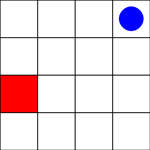

Iteration 500/500
Target: [0 2]
  agent: [3 0], visits: 500, value: 0.16
    ↓ agent: [3 1], visits: 116, value: 0.16
       ← agent: [2 0], visits: 23, value: 0.11
          ← agent: [2 0], visits: 6, value: 0.15
          ↑ agent: [3 0], visits: 5, value: 0.0
          ↓ agent: [3 1], visits: 4, value: 0.0
          → agent: [3 0], visits: 7, value: 0.26
       ↓ agent: [3 1], visits: 31, value: 0.2
          ↑ agent: [3 0], visits: 8, value: 0.21
          → agent: [3 0], visits: 5, value: 0.0
          ↓ agent: [3 1], visits: 11, value: 0.4
          ← agent: [2 0], visits: 6, value: 0.15
       → agent: [3 0], visits: 31, value: 0.21
          ↑ agent: [3 0], visits: 10, value: 0.35
          → agent: [3 0], visits: 8, value: 0.23
          ← agent: [2 0], visits: 7, value: 0.26
          ↓ agent: [3 1], visits: 5, value: 0.0
       ↑ agent: [3 0], visits: 30, value: 0.18
          ← agent: [2 0], visits: 7, value: 0.13
          → agent: [3 0], visits: 11, value: 0.39
          ↑

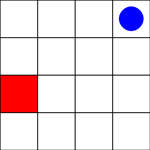

Iteration 500/500
Target: [0 2]
 ↑ agent: [3 0], visits: 636, value: 0.16
    ↓ agent: [3 1], visits: 154, value: 0.18
       ↑ agent: [3 0], visits: 39, value: 0.2
          ↑ agent: [3 0], visits: 8, value: 0.11
          → agent: [3 0], visits: 7, value: 0.0
          ↓ agent: [3 1], visits: 14, value: 0.35
          ← agent: [2 0], visits: 9, value: 0.19
       → agent: [3 0], visits: 46, value: 0.25
          ← agent: [2 0], visits: 14, value: 0.35
          → agent: [3 0], visits: 7, value: 0.0
          ↑ agent: [3 0], visits: 12, value: 0.28
          ↓ agent: [3 1], visits: 12, value: 0.29
       ← agent: [2 0], visits: 39, value: 0.2
          ← agent: [2 0], visits: 8, value: 0.11
          ↑ agent: [3 0], visits: 13, value: 0.39
          → agent: [3 0], visits: 8, value: 0.11
          ↓ agent: [3 1], visits: 9, value: 0.2
       ↓ agent: [3 1], visits: 29, value: 0.12
          → agent: [3 0], visits: 7, value: 0.14
          ↑ agent: [3 0], visits: 7, value: 0.14
       

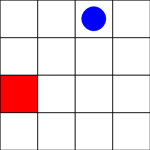

Iteration 500/500
Target: [0 2]
 ← agent: [2 0], visits: 687, value: 0.17
    → agent: [3 0], visits: 165, value: 0.19
       ↓ agent: [3 1], visits: 31, value: 0.13
          ← agent: [2 0], visits: 9, value: 0.19
          → agent: [3 0], visits: 8, value: 0.11
          ↑ agent: [3 0], visits: 7, value: 0.13
          ↓ agent: [3 1], visits: 6, value: 0.0
       ↑ agent: [3 0], visits: 49, value: 0.25
          ← agent: [2 0], visits: 16, value: 0.37
          ↑ agent: [3 0], visits: 10, value: 0.16
          ↓ agent: [3 1], visits: 10, value: 0.17
          → agent: [3 0], visits: 12, value: 0.29
       → agent: [3 0], visits: 45, value: 0.22
          ↓ agent: [3 1], visits: 11, value: 0.23
          ← agent: [2 0], visits: 12, value: 0.29
          → agent: [3 0], visits: 14, value: 0.3
          ↑ agent: [3 0], visits: 7, value: 0.0
       ← agent: [2 0], visits: 39, value: 0.19
          ↑ agent: [3 0], visits: 11, value: 0.24
          → agent: [3 0], visits: 8, value: 0.12
  

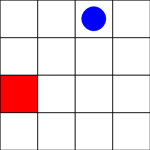

Iteration 500/500
Target: [0 2]
 ↑ agent: [3 0], visits: 710, value: 0.17
    ← agent: [2 0], visits: 221, value: 0.21
       ↑ agent: [3 0], visits: 50, value: 0.21
          ↑ agent: [3 0], visits: 9, value: 0.1
          → agent: [3 0], visits: 18, value: 0.37
          ↓ agent: [3 1], visits: 10, value: 0.17
          ← agent: [2 0], visits: 12, value: 0.22
       → agent: [3 0], visits: 55, value: 0.23
          ← agent: [2 0], visits: 14, value: 0.26
          ↓ agent: [3 1], visits: 14, value: 0.3
          ↑ agent: [3 0], visits: 14, value: 0.26
          → agent: [3 0], visits: 12, value: 0.21
       ← agent: [2 0], visits: 53, value: 0.23
          ↑ agent: [3 0], visits: 9, value: 0.09
          ← agent: [2 0], visits: 15, value: 0.29
          ↓ agent: [3 1], visits: 19, value: 0.41
          → agent: [3 0], visits: 9, value: 0.09
       ↓ agent: [3 1], visits: 62, value: 0.26
          ← agent: [2 0], visits: 19, value: 0.35
          ↓ agent: [3 1], visits: 14, value: 0.2

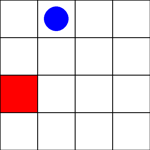

Iteration 500/500
Target: [0 2]
 ← agent: [2 0], visits: 721, value: 0.17
    ↑ agent: [3 0], visits: 169, value: 0.18
       ↑ agent: [3 0], visits: 44, value: 0.21
          → agent: [3 0], visits: 12, value: 0.29
          ↑ agent: [3 0], visits: 12, value: 0.29
          ↓ agent: [3 1], visits: 8, value: 0.1
          ← agent: [2 0], visits: 11, value: 0.23
       → agent: [3 0], visits: 54, value: 0.25
          ↓ agent: [3 1], visits: 12, value: 0.22
          ↑ agent: [3 0], visits: 13, value: 0.27
          → agent: [3 0], visits: 15, value: 0.29
          ← agent: [2 0], visits: 13, value: 0.26
       ↓ agent: [3 1], visits: 32, value: 0.13
          ↓ agent: [3 1], visits: 12, value: 0.3
          ← agent: [2 0], visits: 6, value: 0.0
          → agent: [3 0], visits: 6, value: 0.0
          ↑ agent: [3 0], visits: 7, value: 0.13
       ← agent: [2 0], visits: 38, value: 0.17
          ← agent: [2 0], visits: 12, value: 0.3
          → agent: [3 0], visits: 9, value: 0.18
   

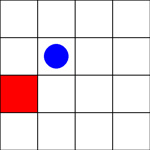

Total reward: 0


In [30]:
# run MCTS on the environment
env = gym.make('GridWorld-v0', render_mode='rgb_array', size=4)
obs, info = env.reset()
render_rgb(env.render())

# Run one episode
total_reward = run_Gridworld_episode(env, obs, print_depth=3)
print(f'Total reward: {total_reward}')

## Tic-Tac-Toe Environment

In [31]:
ttt_env = gym.make('tictactoe-v0') 
ttt_env.reset()
print(ttt_env.get_valid_moves())
print(ttt_env.step((0,1)))
ttt_env.render()
print(ttt_env.step((1,5)))
ttt_env.render()

[0, 1, 2, 3, 4, 5, 6, 7, 8]
(3, 0, False, False, {'info': 'normal move player 1'})
| |O| |
| | | |
| | | |

(489, 0, False, False, {'info': 'normal move player 2'})
| |O| |
| | |X|
| | | |



In [32]:
def run_ttt_episode(env, obs, print_depth=0):
    terminated = False
    total_reward = 0
    
    # Copy the env for MCTS simulations
    mcts_env = deepcopy(env)
    mcts = MCTS(mcts_env, obs, iter_budget=100, discount=0.9)

    # Other option: 
    while not terminated:
        # Agent step
        action = mcts.mcts_find_action(print_depth=print_depth)
        obs, reward, terminated, truncated, info = env.step(action)
        print(f'Selected action: {action} Info: {info}')
        total_reward += reward
        # print(f'Obs: {obs}')
        env.render()
        if terminated:
            print('Terminated')
            break
        # Set the root node to the child node corresponding to the action
        mcts.root = [child for child in mcts.root.children if child.action == action][0]
        mcts.root.parent = None
        # Opponent step
        action_opp = opponent_random(env, player=1)
        obs, _ , terminated, truncated, info = env.step(action_opp)
        print(f'Opponent action: {action_opp} Info: {info}')
        env.render()
        if terminated:
            print('Terminated:', info)
            break
    return total_reward

Agent (player 1): O  
Random opponent (player 2): X

In [37]:
obs = ttt_env.reset()
run_ttt_episode(ttt_env, obs, print_depth=1)

Iteration 100/100
 Action: None, visits: 100,  value: 6.96, State: 0,
    Action: (0, 7), visits: 8,  value: 6.88, State: 2187,
    Action: (0, 3), visits: 1,  value: 0.0, State: 27,
    Action: (0, 1), visits: 3,  value: 6.33, State: 3,
    Action: (0, 4), visits: 1,  value: 0.0, State: 81,
    Action: (0, 2), visits: 21,  value: 8.19, State: 9,
    Action: (0, 8), visits: 1,  value: 0.0, State: 6561,
    Action: (0, 7), visits: 1,  value: 0.0, State: 2187,
    Action: (0, 6), visits: 21,  value: 8.19, State: 729,
    Action: (0, 0), visits: 38,  value: 8.36, State: 1,
    Action: (0, 5), visits: 5,  value: 7.4, State: 243,
Selected action: (0, 0) Info: {'info': 'normal move player 1'}
|O| | |
| | | |
| | | |

Opponent action: (1, 7) Info: {'info': 'normal move player 2'}
|O| | |
| | | |
| |X| |

Iteration 100/100
 Action: (0, 0), visits: 138,  value: 7.06, State: 1,
    Action: (0, 8), visits: 21,  value: 7.8, State: 6561,
    Action: (0, 7), visits: 5,  value: 7.4, State: 2187,
    

10